#### Now that you’ve found the answers to the questions above, design two of your own questions to answer. These should be sufficiently difficult, and you should be creative! You should start with a question, and then propose a predicted answer or hypothesis before writing a MapReduce job to answer it. If you come up with a particularly challenging question, it can count for two (ask first). Some ideas:

Make predictions / classifications using ML models
Visualization of related features. Your visualization should help tell a story.
Clustering related users, comments, or subreddits
Summary statistics: finding mins, maxes, standard deviations, or even correlations between variables to tell us something about a subreddit or multiple subreddits. For example, perhaps users that visit /r/technology also frequently visit /r/android.
Friend graph: can you link together ‘related’ users based on some shared interest? Maybe several users visit the same collection of subreddits. The PageRank could come in handy here.

### Questions
1. How are number of commenters related to time series ?
2. How is toxicity in Reddit related to time series ?

#### Loading sample data into dataframe






In [1]:
# from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import from_json, col
conf = SparkConf().setAppName('FirstSpark2').setMaster('Spark')
sc = SparkContext.getOrCreate()

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
df = sqlContext.read.json("hdfs://orion11:20001/sample_sampled_reddit/")


#### Filtering dataset

In [2]:
df2 = df.filter(
~(df.body.like('[deleted]'))
    & ~(df.body.isNull())
    & ~(df.author.like('[deleted]'))
    & ~(df.author.like('AutoModerator')) 
    & ~(df.author.rlike("[bB][oO][tT]"))

)

print(type(df2))
print(df2.count())
df2.show(1)

<class 'pyspark.sql.dataframe.DataFrame'>
27303462
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+------------+-----+-----+------------+--------+---------------+------------+---+------------+
|archived|        author|author_cakeday|author_flair_css_class|author_flair_text|                body|body_html|controversiality|created|created_utc|distinguished|downs|edited|gilded|     id|  link_id|mod_reports|name|parent_id|removal_reason|replies|retrieved_on|saved|score|score_hidden|stickied|      subreddit|subreddit_id|ups|user_reports|
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+--------

### Predicting number of distinct users commenting on a reddit for a given year and month

In [4]:
from pyspark.sql.functions import year, month, dayofmonth, from_unixtime
from pyspark.sql.types import DateType

pred_df = (df2
      .withColumn("year", year(from_unixtime("created_utc").cast(DateType())))
      .withColumn("month",month(from_unixtime("created_utc").cast(DateType())))
      )
pred_df.show(2)

+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+------------+-----+-----+------------+--------+---------------+------------+---+------------+----+-----+
|archived|        author|author_cakeday|author_flair_css_class|author_flair_text|                body|body_html|controversiality|created|created_utc|distinguished|downs|edited|gilded|     id|  link_id|mod_reports|name|parent_id|removal_reason|replies|retrieved_on|saved|score|score_hidden|stickied|      subreddit|subreddit_id|ups|user_reports|year|month|
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+------------+-----+-----+------------

In [14]:
from pyspark.sql.functions import countDistinct

# pred_df1 = pred_df.groupBy("year","month", "subreddit")
pred_df1 = pred_df.groupBy("year","month")
pred_df1 = pred_df1.agg(countDistinct("author").alias("author_count"))

pred_df1.show(20)

+----+-----+------------+
|year|month|author_count|
+----+-----+------------+
|2012|   10|      132550|
|2007|    6|         802|
|2010|   12|       30085|
|2010|    7|       19348|
|2015|    2|      280120|
+----+-----+------------+
only showing top 5 rows



#### Viewing it in chart

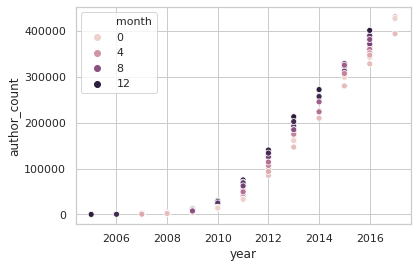

In [46]:
import seaborn as sns

# scatter_df = pred_df1

scatter_df_P = pred_df1.toPandas()


ax = sns.scatterplot(x="year", y="author_count", hue="month", data=scatter_df_P)

##### > We can see that since 2010 there has been rise liner rise in number of users commenting on reddit

### Let us run a prediction model

#### Breaking data into train and test

In [25]:
m_data = pred_df1.where(pred_df1.year!=2017).toPandas()
# Filter rows with missing values
# melbourne_data = melbourne_data.dropna(axis=0)
# Choose target and features
y = m_data.author_count
m_features = ['year', 'month']
X = m_data[m_features]

from sklearn.model_selection import train_test_split

# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

#### Training and testing performance

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

forest_model0 = RandomForestRegressor(random_state=1)
forest_model0.fit(train_X, train_y)
m_preds0 = forest_model0.predict(val_X)
print(mean_absolute_error(val_y, m_preds0))

forest_model = LinearRegression()
forest_model.fit(train_X, train_y)
m_preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, m_preds))

5127.858823529412
38849.363339754585


/home2/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### > Random Forest Regressor is performing much better than Linear regression. So we will use Random forest regressor as our chosen model

#### Predicting distinct users 

In [38]:
import numpy as np

np_a = np.array([[2007, 6]])
np_a_preds0 = forest_model0.predict(np_a)
print(np_a_preds0)
np_a = np.array([[2011, 6]])
np_a_preds0 = forest_model0.predict(np_a)
print(np_a_preds0)
np_a = np.array([[2015, 6]])
np_a_preds0 = forest_model0.predict(np_a)
print(np_a_preds0)
np_a = np.array([[2018, 6]])
np_a_preds0 = forest_model0.predict(np_a)
print(np_a_preds0)

[804.4]
[47042.8]
[305486.]
[360838.9]


### Checking the toxicity on reddit year on year

#### Adding sentiment to each row

In [53]:
%%time

# import nltk
# nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

from pyspark.sql import functions as F
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import *

# pattern = "\b[A-Z]+"

def getSentiment(body):
    ss = sid.polarity_scores(body)
    print(ss)
    return ss["compound"]

Score = udf(getSentiment, DoubleType())
sent_df = pred_df.withColumn('sentiment', Score("body"))
sent_df.show(1)

+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+------------+-----+-----+------------+--------+---------------+------------+---+------------+----+-----+---------+
|archived|        author|author_cakeday|author_flair_css_class|author_flair_text|                body|body_html|controversiality|created|created_utc|distinguished|downs|edited|gilded|     id|  link_id|mod_reports|name|parent_id|removal_reason|replies|retrieved_on|saved|score|score_hidden|stickied|      subreddit|subreddit_id|ups|user_reports|year|month|sentiment|
+--------+--------------+--------------+----------------------+-----------------+--------------------+---------+----------------+-------+-----------+-------------+-----+------+------+-------+---------+-----------+----+---------+--------------+-------+------------+----

In [54]:
from pyspark.sql.functions import avg

sent_df1 = sent_df.groupBy("year","month")
sent_df1 = sent_df1.agg(avg("sentiment").alias("avg_sentiment"))

sent_df1.show(20)

+----+-----+--------------------+
|year|month|       avg_sentiment|
+----+-----+--------------------+
|2012|   10| 0.12465327520245463|
|2007|    6| 0.04246504347826081|
|2010|    7| 0.11269978628389155|
|2010|   12| 0.12465467038226721|
|2015|    2| 0.13628438325462214|
|2017|    3| 0.13032242142340375|
|2008|    8| 0.05066389743589743|
|2014|    4| 0.14040690795773542|
|2009|   11| 0.10186279909973925|
|2016|    7| 0.12330122318435041|
|2015|   12| 0.12765723653943128|
|2016|   11| 0.12239789460491496|
|2013|    2| 0.13258108911676086|
|2012|    8| 0.12881099775652374|
|2012|    4| 0.12816685179603282|
|2012|   12| 0.12294370010026336|
|2006|   12|   0.071960327198364|
|2007|    1| 0.08725232358003439|
|2007|   10| 0.07390407138873399|
|2006|    7|0.039474903474903435|
+----+-----+--------------------+
only showing top 20 rows



#### Veiwing it in chart

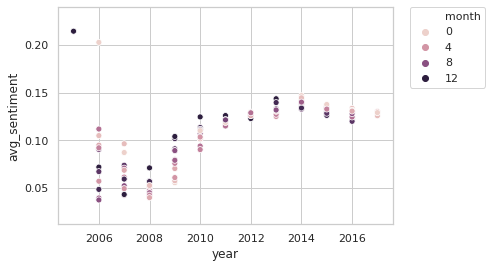

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# scatter_df = pred_df1

scatter_df_S = sent_df1.toPandas()


ax = sns.scatterplot(x="year", y="avg_sentiment", hue="month", data=scatter_df_S)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### > We see that avg sentiment of reddit saw an increase from 2008 to 2013, since then it has stagnated a bit

### Let us run a prediction model

#### Breaking data into train and test

In [56]:
m_data = sent_df1.where(pred_df1.year!=2017).toPandas()
# Filter rows with missing values
# melbourne_data = melbourne_data.dropna(axis=0)
# Choose target and features
y = m_data.avg_sentiment
m_features = ['year', 'month']
X = m_data[m_features]

from sklearn.model_selection import train_test_split

# split data into training and validation data, for both features and target
# The split is based on a random number generator. Supplying a numeric value to
# the random_state argument guarantees we get the same split every time we
# run this script.
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

#### Training and testing performance

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

forest_model0 = RandomForestRegressor(random_state=1)
forest_model0.fit(train_X, train_y)
m_preds0 = forest_model0.predict(val_X)
print(mean_absolute_error(val_y, m_preds0))

forest_model = LinearRegression()
forest_model.fit(train_X, train_y)
m_preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, m_preds))

0.0049379940550915635
0.015194474608656609


/home2/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### > We see that Random Forest regressor, performs much better than Linear Regression, so choosing Random Forest model 

#### Predicting distinct users 

In [65]:
import numpy as np

np_a = np.array([[2007, 6]])
np_a_preds0 = forest_model0.predict(np_a)
print(np_a_preds0)
np_a = np.array([[2010, 7]])
np_a_preds0 = forest_model0.predict(np_a)
print(np_a_preds0)
np_a = np.array([[2014, 7]])
np_a_preds0 = forest_model0.predict(np_a)
print(np_a_preds0)
np_a = np.array([[2020, 6]])
np_a_preds0 = forest_model0.predict(np_a)
print(np_a_preds0)

[0.05166666]
[0.10556862]
[0.13642019]
[0.12593705]


### Here we perform KMean Clustering to check which subreddits are close to each other in terms of sentiment

In [8]:
dffiltered = df3.select('subreddit_id','sentiment')
dffiltered.show(2)

+------------+---------+
|subreddit_id|sentiment|
+------------+---------+
|    t5_2rv3t|   0.9129|
|    t5_2qhl2|  -0.8951|
+------------+---------+
only showing top 2 rows



In [10]:

def getCount(id):
    return 1.0

getCount = udf(getCount, DoubleType())

dffiltered = dffiltered.withColumn('count',getCount('subreddit_id'))
dffiltered.show(2)

+------------+---------+-----+
|subreddit_id|sentiment|count|
+------------+---------+-----+
|    t5_2rv3t|   0.9129|  1.0|
|    t5_2qhl2|  -0.8951|  1.0|
+------------+---------+-----+
only showing top 2 rows



In [15]:
from pyspark.sql import functions as F

grouped2 = dffiltered.groupBy('subreddit_id').agg(F.avg('sentiment'), F.sum('count'))
grouped2.show(2)

+------------+-------------------+----------+
|subreddit_id|     avg(sentiment)|sum(count)|
+------------+-------------------+----------+
|    t5_2r7qs|0.15442861386138623|    1010.0|
|    t5_2ybvq|           0.267835|      20.0|
+------------+-------------------+----------+
only showing top 2 rows



In [18]:
FEATURES_COL = ['avg(sentiment)', 'sum(count)']

for col_name in FEATURES_COL:
    df = grouped2.withColumn(col_name, col(col_name).cast('float'))
    
df.show(2)

+------------+-------------------+----------+
|subreddit_id|     avg(sentiment)|sum(count)|
+------------+-------------------+----------+
|    t5_2uu0j|0.18739892733041247|    6619.0|
|    t5_326m9|0.10993841650812233|    6833.0|
+------------+-------------------+----------+
only showing top 2 rows



In [19]:
df = df.na.drop()
df.show()

+------------+-------------------+----------+
|subreddit_id|     avg(sentiment)|sum(count)|
+------------+-------------------+----------+
|    t5_2uu0j| 0.1873989273304124|    6619.0|
|    t5_326m9|0.10993841650812235|    6833.0|
|    t5_32ob1|0.19885257703081213|    3570.0|
|    t5_3d0v5|0.11405110759493672|     632.0|
|    t5_2skgl|0.14036860465116277|    1204.0|
|    t5_2rnei|0.09983304221251818|     687.0|
|    t5_31fm3|0.14004727921498655|    1121.0|
|    t5_2rtpo|0.22175964912280707|     456.0|
|    t5_3c2d7| 0.1553663432118192|   11439.0|
|    t5_2qh84| 0.2704192504258945|     587.0|
|    t5_3a1r5|0.24355500000000002|      20.0|
|    t5_2r7qs|0.15442861386138612|    1010.0|
|    t5_2sqvk| 0.2548759098786829|     577.0|
|    t5_2s7xm|0.19201274298056156|     463.0|
|    t5_2t34b|0.11871242424242417|     660.0|
|    t5_38c1l|                0.0|       1.0|
|    t5_2yq3c|0.27494272151898735|     316.0|
|    t5_2y6h2|0.28802812499999997|      96.0|
|    t5_39dwd|           0.433225|

#### Create a features column to be used in the clustering

In [20]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df).select('subreddit_id', 'features')
df_kmeans.show()

+------------+--------------------+
|subreddit_id|            features|
+------------+--------------------+
|    t5_3c2d7|[0.15536634321181...|
|    t5_2uu0j|[0.18739892733041...|
|    t5_32ob1|[0.19885257703081...|
|    t5_32ntp|[0.14690863874345...|
|    t5_326m9|[0.10993841650812...|
|    t5_2quz8|[0.12214671916010...|
|    t5_2skgl|[0.14036860465116...|
|    t5_2sqvk|[0.25487590987868...|
|    t5_2rnei|[0.09983304221251...|
|    t5_37748|[0.01622842105263...|
|    t5_2qhsb|[-0.0014160493827...|
|    t5_3eu9i|[0.02096153846153...|
|    t5_3g70s|[0.13603632862644...|
|    t5_3cigp|[0.18772999999999...|
|    t5_2s7xm|[0.19201274298056...|
|    t5_31fm3|[0.14004727921498...|
|    t5_2sj2w|[0.27673762237762...|
|    t5_3infp|[0.31976842105263...|
|    t5_2tzv3|[0.03324651162790...|
|    t5_2sn2r|[0.22073896103896...|
+------------+--------------------+
only showing top 20 rows



#### Optimize choice of k


In [ ]:
import numpy as np
import pandas as pd

cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(df_kmeans) # requires Spark 2.0 or later

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

#### Training the machine learning model

In [ ]:
k = 10
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

#### Assign clusters to event

In [ ]:
transformed = model.transform(df_kmeans).select('subreddit_id', 'prediction')
rows = transformed.collect()
print(rows[:3])

In [ ]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()